<a href="https://colab.research.google.com/github/XuguangAi/BMI733/blob/main/CNN%26RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow-addons

In [15]:
import os # setting working directory
import numpy as np # for generating random embeddings
import pandas as pd # importing a csv
import random
import spacy # basic text processing
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
plt.style.use('ggplot')
from statistics import harmonic_mean
import pickle
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, Bidirectional, Dense, Concatenate, GlobalMaxPooling1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import pickle

In [16]:
file_path='/content/dataset_CNN&RNN.zip'
def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path) 

'Data has been extracted'

In [17]:
dataset_dir = '/content/dataset'

In [18]:
# sets pseudorandom seeds
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)    

### TPU usage
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.83.211.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.83.211.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [19]:
%cd '/content/dataset_CNN&RNN'

/content/dataset_CNN&RNN


In [21]:
x_large = pickle.load(open('x_training', "rb"))
x_test = pickle.load(open('x_testing', "rb"))
y_large = pickle.load(open('y_training', "rb"))
y_test = pickle.load(open('y_testing', "rb"))

In [31]:
# word embeddings
embeddings_pretrained = pickle.load(open('embeddings_w2v', "rb" ) )
embeddings_random = pickle.load(open('embeddings_random', "rb"))

# maximum text sequence length
max_len = pickle.load(open('max_len', "rb"))

# number and dimension of word embeddings
dim_embed = embeddings_pretrained.shape[1]
num_embed = embeddings_pretrained.shape[0]

In [32]:
x_train, x_valid, y_train, y_valid = train_test_split(x_large, y_large, test_size = 0.2, random_state = 0)

In [33]:
class Conv1D_multiple_filters(keras.layers.Layer):
    # intializes class attributes
    def __init__(self, filter_size_list, filter_num_list, activation, pooling_fun):
        super().__init__()
         
        self.num_window_sizes = len(filter_size_list)
        self.convolutions_list = [Conv1D(filter_num_list[i],
                                   filter_size_list[i],
                                   activation = activation)
                             for i in range(self.num_window_sizes)
                             ]
        self.pooling_fun = pooling_fun()
        self.concat = Concatenate()
        
    def call(self, x):
        # runs n-grams through convolutions with activation functions
        x = [self.convolutions_list[i](x) for i in range(self.num_window_sizes)]
        
        # pooling
        x = [self.pooling_fun(x[i]) for i in range(self.num_window_sizes)]
                
        # concatenates results from different filter sizes.  If only bigrams are used, then there is not concatentation to be done.
        if len(x) == 1:
            x = x[0] # list of 1 tensor -> tensor
        elif len(x) > 1:
            x = self.concat(x) # concatentates list of >1 tensors to one tensor.

        return x

In [34]:
class F1(tf.keras.metrics.Metric):
    # initializing class object
    def __init__(self, name='F1', **kwargs):
        super(F1, self).__init__(name=name, **kwargs)
        
        # intializes # TP's, FP's, and FN's to 0
        self.TP = self.add_weight(name='TP', initializer='zeros')
        self.FP = self.add_weight(name='FP', initializer='zeros')
        self.FN = self.add_weight(name='FN', initializer='zeros')

    # accumulates TP's, FP's, and FN's over batches in epoch
    def update_state(self, y_true, y_pred, sample_weight = None):
        
        # converts probability score to boolean
        y_pred = tf.where(y_pred > 0.5, True, False)

        # ensures quantities are boolean
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)
        
        # calculates # TP's, FP's, FN's in batch
        TP_tensor = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        TP_tensor = tf.cast(TP_tensor, self.dtype)
        TP = tf.reduce_sum(TP_tensor)
        
        FP_tensor = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        FP_tensor = tf.cast(FP_tensor, self.dtype)
        FP = tf.reduce_sum(FP_tensor)
        
        FN_tensor = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        FN_tensor = tf.cast(FN_tensor, self.dtype)
        FN = tf.reduce_sum(FN_tensor)
        
        # adds TP's, FP's and FN's to those of previous batches in epoch
        self.TP.assign_add(TP)
        self.FP.assign_add(FP)
        self.FN.assign_add(FN)
    
    # calculates F-score
    def result(self):
        
        precision = tf.math.divide(self.TP, tf.math.add(self.TP, self.FP))
        recall = tf.math.divide(self.TP, tf.math.add(self.TP, self.FN))
        
        numerator = 2 * tf.math.multiply(precision, recall)
        denominator = tf.math.add(precision, recall)
        
        F1 = tf.math.divide(numerator, denominator)
        
        return F1
    
    # resets TP's, FP's, and FN's to 0 at the end of epoch
    def reset_state(self):
        self.TP.assign(0)
        self.FP.assign(0)
        self.FN.assign(0)

In [35]:
def plot_loss(history):
    val_loss = history.history['val_loss']
    epochs = range(1, len(val_loss) + 1)

    plt.plot(epochs, val_loss, 'b')
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()

def plot_F1(history):
    val_f1 = history.history['val_F1']
    epochs = range(1, len(val_f1) + 1)

    plt.plot(epochs, val_f1, 'b')
    plt.xlabel("Epoch")
    plt.ylabel("Validation F1")
    plt.legend()

In [46]:
########################### Modeling choices ##############################
# choice between pretrained and random word embeddings (comment out one of the choices to use the other) - # student modifies this section
embedding_matrix = embeddings_pretrained
#embedding_matrix = embeddings_random

# CNN hyperparameter choices - student modifies this section
num_filters = 2400 # optional to modify
max_ngram = 6 # do 2,3,4,5

# biLSTM hyperparameter choices  - student modifies this section
rnn_dim_hidden = 256 # note this is for each of the two LSTMs

# mini-batch size (optional to modify)
batch_size = 32
num_epochs = 30

# dropout (optional to modify)
prob_dropout_input = 0.5
prob_dropout_after_NN = 0.5
prob_dropout_rnn = 0.5

In [47]:
##################################### model definition #############################################
# splits number of filters evenly into filter sizes, and if it doesn't divide evenly, adds one filter to smaller filter sizes until none left
filter_size_list = list(range(2, max_ngram + 1))
filter_num_list = [num_filters//(max_ngram - 1)] * (max_ngram - 1)
remainder = num_filters % (max_ngram - 1)
for i in range(remainder):
    filter_num_list[i] += 1

# sets pseudorandom seeds
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

##### defining the model
with tpu_strategy.scope():

    # using the Sequential module
    model = Sequential()

    # adds word embedding layer to model
    model.add(Embedding(num_embed, dim_embed, 
                               weights=[embedding_matrix], 
                               input_length = max_len, 
                               trainable = False))

    # dropout
    model.add(Dropout(prob_dropout_input))

    ### adds CNN or biLSM (choose by commenting out one of these lines) - student modifies this section
    model.add(Conv1D_multiple_filters(filter_size_list, filter_num_list, activation = 'relu', pooling_fun = GlobalMaxPooling1D))
    #model.add(Bidirectional(LSTM(rnn_dim_hidden, recurrent_dropout = prob_dropout_rnn)))
    ###

    # dropout
    model.add(Dropout(prob_dropout_after_NN))

    # adds a MLP(1) layer
    model.add(Dense(1, activation = 'sigmoid'))


    # chooses loss function, optimizer, and evaluation metrics
    fscore = F1()
    model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['Precision', 'Recall', fscore])

    # prints model structure summary (just for user)
    model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 116, 300)          8986500   
                                                                 
 dropout_6 (Dropout)         (None, 116, 300)          0         
                                                                 
 conv1d_multiple_filters_2 (  (None, 2400)             2882400   
 Conv1D_multiple_filters)                                        
                                                                 
 dropout_7 (Dropout)         (None, 2400)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2401      
                                                                 
Total params: 11,871,301
Trainable params: 2,884,801
Non-trainable params: 8,986,500
___________________________________

In [48]:
################################ model fitting ###############################

# stops training when the model fails to improve validation loss for 20 epochs, and selects the best model 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_F1',
                                                  mode = 'max',
                                                  patience = 10,
                                                  restore_best_weights = True)


# trains model
history = model.fit(x_train, y_train,
                    epochs = num_epochs,
                    verbose = 1, # change to 0 if you don't want to print intermediate results during training
                    validation_data = (x_valid, y_valid),
                    batch_size = batch_size,
                    validation_batch_size = len(y_valid),
                    callbacks = [early_stopping])

Epoch 1/30
2000/2000 [==============================] - 50s 22ms/step - loss: 0.7456 - precision: 0.4968 - recall: 0.4362 - F1: 0.4645 - val_loss: 0.6868 - val_precision: 0.5155 - val_recall: 0.6310 - val_F1: 0.5674
Epoch 2/30
2000/2000 [==============================] - 41s 21ms/step - loss: 0.7096 - precision: 0.5094 - recall: 0.4326 - F1: 0.4679 - val_loss: 0.6893 - val_precision: 0.5503 - val_recall: 0.2343 - val_F1: 0.3286
Epoch 3/30
2000/2000 [==============================] - 41s 21ms/step - loss: 0.7111 - precision: 0.5172 - recall: 0.4390 - F1: 0.4749 - val_loss: 0.6953 - val_precision: 0.5051 - val_recall: 0.6828 - val_F1: 0.5807
Epoch 4/30
2000/2000 [==============================] - 42s 21ms/step - loss: 0.7089 - precision: 0.5267 - recall: 0.4449 - F1: 0.4824 - val_loss: 0.6838 - val_precision: 0.5402 - val_recall: 0.3650 - val_F1: 0.4356
Epoch 5/30
2000/2000 [==============================] - 41s 20ms/step - loss: 0.7082 - precision: 0.5276 - recall: 0.4473 - F1: 0.4841 -

In [49]:
###################### Performance #############################
# prediction 
y_pred = np.round(model.predict(x_test)).flatten()

# performance measures
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average = 'binary')

# printing
print('precision : ', precision)
print('recall : ', recall)
print('F1 : ', f1)

precision :  0.4909813269765594
recall :  0.6713385484571925
F1 :  0.5671669190876131


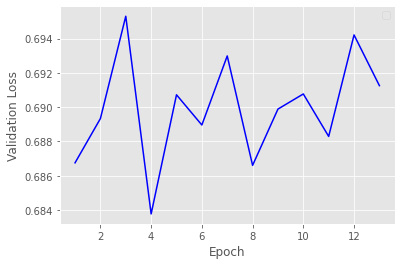

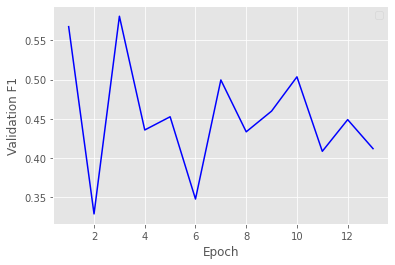

In [50]:
#################### Plotting #################
plot_loss(history)
plt.show()
plot_F1(history)
plt.show()